# Elastic Net

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, ElasticNet
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from preprocessing import oneOutOfK, missing_predictor_as_mean, missing_predictor_as_value, missing_predictor_as_knn
from sklearn.model_selection import KFold
import scipy.linalg as lng
import matplotlib.colors as colors
from helpers import RMSE, center, normalize, normalizetest 

# load and display data

In [2]:
data = pd.read_csv('Case1_Data.csv')
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# split data in training / prediction based of Y value
training = data.loc[data['Y'].notnull()]
prediction = data.loc[data['Y'].isnull()]

train_y = training['Y'].values
train_X = training[[col for col in training.columns if col != 'Y']].values


# One out of K encoding for categorical value
train_X = oneOutOfK(train_X, 99).astype(float)


# replace missing values with mean of column
train_X_mn = missing_predictor_as_mean(train_X)

# replace missing values with mean of KNN
clean_data = missing_predictor_as_value(train_X, 0)
train_X_knn = missing_predictor_as_knn(5, train_X, clean_data)

# split Train / Test (70% / 30%) (for train_X)
test_split_ratio = 0.3

# Global variables

In [3]:
# Flag for what handling of missing values to use
KNN_rpl = True

if (KNN_rpl):
    X_train, X_test, y_train , y_test= train_test_split(train_X_knn, train_y, test_size=test_split_ratio, random_state=0)
else:
    X_train, X_test, y_train , y_test= train_test_split(train_X_mn, train_y, test_size=test_split_ratio, random_state=0)


# First, we'll establish a baseline for the prediction with OLS 
# on the data with NaN's replaced with the column's mean
 # Linear solver
[n_train, p_train], [n_test, p_test] = np.shape(X_train), np.shape(X_test)

# alphas = range(0,11,1) # Ratio between L1 and L2 norms
#ratios = range(0,11,1)
ratios = [0, 5, 10]
k = 100; # try k values of lambda
lambdas = np.logspace(-2, 0, k)
'''
# Working lambdas
lambdas = np.logspace(-2, 1, k)
'''
# Number of folds
K = 10  


# Different errors
training_error = np.zeros((K, k, len(ratios)))
testing_error = np.zeros((K, k, len(ratios)))
K_elasticNet = np.empty((K, k, len(ratios)))
training_RMSE = np.zeros((K, k, len(ratios)))
test_RMSE = np.zeros((K, k, len(ratios)))

# Cross-validation

In [4]:
# K - fold cross validation 
kf = KFold(K, shuffle=False)

In [5]:
for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    X_train_cv, X_val = X_train[train_index], X_train[test_index]
    y_train_cv, y_val = y_train[train_index], y_train[test_index]
    
    for k, l in enumerate(lambdas):
        for j, ratio in enumerate(ratios):
            regr = ElasticNet(alpha=l, l1_ratio= (ratio / 10), fit_intercept=True, normalize=True)
            regr.fit(X_train_cv, y_train_cv)
            beta = regr.coef_
    
            y_hat_val = np.matmul(X_val, beta)
            y_hat_train = np.matmul(X_train, beta)  
            
            
            training_RMSE[(i-1), k, j] = RMSE(y_train, y_hat_train)
            training_error[(i-1), k, j ] = np.mean((y_train - y_hat_train)**2)
            
            test_RMSE[(i-1), k, j] = RMSE(y_val, y_hat_val)
            testing_error[(i-1), k, j ] = np.mean((y_val - y_hat_val)**2)
            
            K_elasticNet[i-1, k, j] = len(np.where(beta != 0)[0])

#mean_error_training = np.mean(training_error, axis=0)
#mean_error_test = np.mean(testing_error, axis=0)
mean_error_training = np.mean(training_RMSE, axis=0)
mean_error_test = np.mean(test_RMSE, axis=0)

k_nonZero_parameters = np.mean(K_elasticNet, axis=0)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [6]:
# Elastic net plot average over all ratios
plt.figure(2)
plotting_training_error = np.mean(mean_error_training, axis=1)
plotting_test_error = np.mean(mean_error_test, axis=1)
plotting_k = np.mean(k_nonZero_parameters, axis=1)
training_error_plot = plt.plot(lambdas, plotting_training_error, label='Training')
test_error_plot = plt.plot(lambdas, plotting_test_error, label='Test')
K_non_zero_plot = plt.plot(lambdas, plotting_k, label='K')

plt.xlabel('Lambda')
plt.ylabel('error estimate')
plt.title("Elastic Net Test vs training RMSE")
plt.legend(['Training', 'Test', 'K'])


#plt.show()

In [7]:
# Elastic net plot average over all ratios
plt.figure(2)
training_error_plot = plt.plot(lambdas, mean_error_training, label='Training')
test_error_plot = plt.plot(lambdas, mean_error_test, label='Test')
K_non_zero_plot = plt.plot(lambdas, k_nonZero_parameters, label='K')

plt.xlabel('Lambda')
plt.ylabel('error estimate')
plt.title("Elastic Net Test vs training RMSE")
plt.legend(['Training', 'Test', 'K'])


#plt.show()

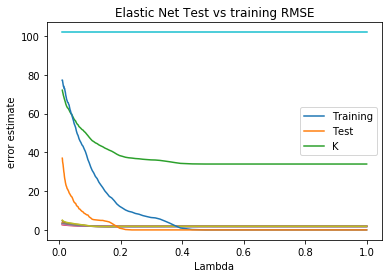

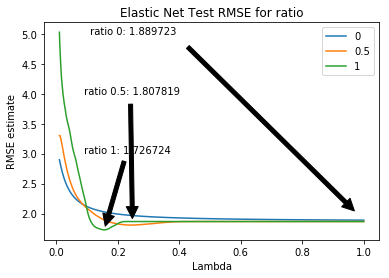

ratio 0: 1.8897233762670482 for lambda 1.0
ratio 0.5: 1.8078192359390666 for lambda 0.24770763559917114
ratio 1: 1.7267239641077137 for lambda 0.15556761439304723


In [8]:
# Elastic net plot average over all ratios
plt.figure(6)
#training_error_plot = plt.plot(lambdas, mean_error_training, label='Training')
test_error_plot = plt.plot(lambdas, mean_error_test, label='Test')
#K_non_zero_plot = plt.plot(lambdas, k_nonZero_parameters, label='K')

plt.xlabel('Lambda')
plt.ylabel('RMSE estimate')
plt.title("Elastic Net Test RMSE for ratio")
plt.legend(['0', '0.5', '1'])

plt.annotate(' ratio 0: {:f}'.format(mean_error_test[:,0].min()), xy=(lambdas[np.argmin(mean_error_test[:,0])],mean_error_test[:,0].min()), xytext=(.1, 5),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

plt.annotate(' ratio 0.5: {:f}'.format(mean_error_test[:,1].min()), xy=(lambdas[np.argmin(mean_error_test[:,1])],mean_error_test[:,1].min()), xytext=(.08, 4),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

plt.annotate(' ratio 1: {:f}'.format(mean_error_test[:,2].min()), xy=(lambdas[np.argmin(mean_error_test[:,2])],mean_error_test[:,2].min()), xytext=(.08, 3),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )


plt.show()

print ("ratio 0: {} for lambda {}".format(mean_error_test[:,0].min(), lambdas[np.argmin(mean_error_test[:,0])]))
print ("ratio 0.5: {} for lambda {}".format(mean_error_test[:,1].min(), lambdas[np.argmin(mean_error_test[:,1])]))
print ("ratio 1: {} for lambda {}".format(mean_error_test[:,2].min(), lambdas[np.argmin(mean_error_test[:,2])]))

# One standard error

99
CV lambda 1 std rule 1.000000


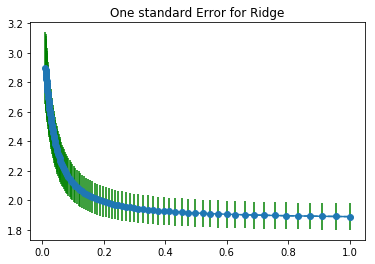

In [9]:
seRMSE = np.std(test_RMSE, axis = 0) / np.sqrt(K)

# For ratio 0

jOpt = np.argmin(seRMSE[:,0])
print (jOpt)

J = np.where(mean_error_test[jOpt] + seRMSE[jOpt] > mean_error_test)[0]
j = int(J[-1:])
Lambda_CV_1StdRule = lambdas[j]

print("CV lambda 1 std rule {:f}".format(Lambda_CV_1StdRule))

plt.figure(7)
plt.plot(lambdas, mean_error_test[:,0], label='Test')
plt.title("One standard Error for Ridge")
plt.errorbar(lambdas, mean_error_test[:,0],  yerr=seRMSE[:,0], fmt='--o', ecolor='g', capthick=2)


plt.show()

75
CV lambda 1 std rule 1.000000


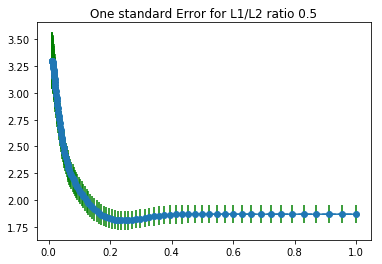

In [10]:
seRMSE = np.std(test_RMSE, axis = 0) / np.sqrt(K)

# For ratio 0

jOpt = np.argmin(seRMSE[:,1])
print(jOpt)

J = np.where(mean_error_test[jOpt] + seRMSE[jOpt] > mean_error_test)[0]
j = int(J[-1:])
Lambda_CV_1StdRule = lambdas[j]

print("CV lambda 1 std rule {:f}".format(Lambda_CV_1StdRule))

plt.figure(8)
plt.plot(lambdas, mean_error_test[:,1], label='Test')
plt.title("One standard Error for L1/L2 ratio 0.5")
plt.errorbar(lambdas, mean_error_test[:,1],  yerr=seRMSE[:,1], fmt='--o', ecolor='g', capthick=2)


plt.show()

66
CV lambda 1 std rule 1.000000


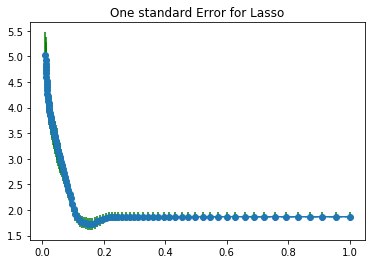

In [11]:
seRMSE = np.std(test_RMSE, axis = 0) / np.sqrt(K)

# For ratio 0

jOpt = np.argmin(seRMSE[:,2])
print (jOpt)

J = np.where(mean_error_test[jOpt] + seRMSE[jOpt] > mean_error_test)[0]
j = int(J[-1:])
Lambda_CV_1StdRule = lambdas[j]

print("CV lambda 1 std rule {:f}".format(Lambda_CV_1StdRule))

plt.figure(9)
plt.plot(lambdas, mean_error_test[:,2], label='Test')
plt.title("One standard Error for Lasso")
plt.errorbar(lambdas, mean_error_test[:,2],  yerr=seRMSE[:,2], fmt='--o', ecolor='g', capthick=2)


plt.show()

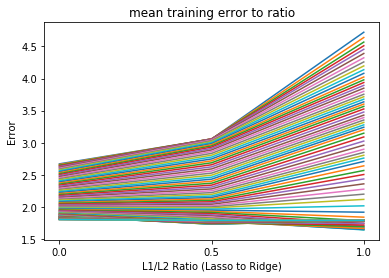

In [12]:
plt.figure(3)
plt.plot(mean_error_training.T)


plt.xlabel('L1/L2 Ratio (Lasso to Ridge)')
plt.ylabel('Error')
plt.title("mean training error to ratio")
#labels = [item.get_text() for item in plt.xticklabels()]
labels = ratios[:]
for k in range(len(ratios)):
    labels[k] = str(float(ratios[k])/10)
plt.xticks(np.arange(0,len(ratios)), labels)

plt.show()

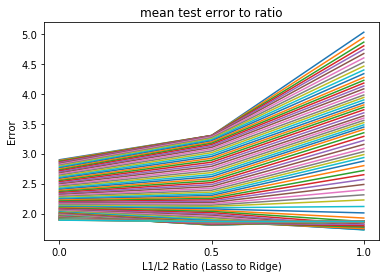

In [13]:
plt.figure(4)
plt.plot(mean_error_test.T)


plt.xlabel('L1/L2 Ratio (Lasso to Ridge)')
plt.ylabel('Error')
plt.title("mean test error to ratio")
labels = ratios[:]
for k in range(len(ratios)):
    labels[k] = str(float(ratios[k])/10)
plt.xticks(np.arange(0,len(ratios)), labels)


plt.show()

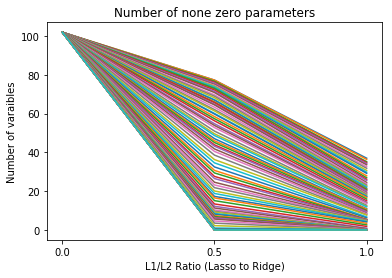

In [14]:
plt.figure(5)
plt.plot(k_nonZero_parameters.T)


plt.xlabel('L1/L2 Ratio (Lasso to Ridge)')
plt.ylabel('Number of varaibles')
plt.title("Number of none zero parameters")
labels = ratios[:]
for k in range(len(ratios)):
    labels[k] = str(float(ratios[k])/10)
plt.xticks(np.arange(0,len(ratios)), labels)

plt.show()

In [15]:
minval = mean_error_test.min()
#print (lambdas)
#print (seRMSE)